# Analyze sessions in batch from Phase 1 of AdaDrive (work in progress)

In [1]:
path_to_base_package = '../..'
import sys
# setting path
sys.path.append(f"{path_to_base_package}")
import mne
mne.viz.set_3d_backend('pyvistaqt')
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mna.utils.data_access import *
from mna.utils.analysis import *
from mne.datasets import fetch_fsaverage
import pickle
# 1. Read a RN App, converted pkl file, and create the metadata and data structure

Using pyvistaqt 3d backend.



# Aux functions, read files

In [2]:
output_dir = f"{path_to_base_package}/output/batch_analysis_motor/"
output_dir_non_baseline_non_average = f"{path_to_base_package}/output/batch_analysis_motor/saved_files_non_baseline_non_average/" # saved files directory (trial or motor)
remove_sessions = [(15,1),(22,1)]
rel_regions, all_region = get_relevant_channels()
rel_labels, rel_mappings = get_relevant_labels_mappings(path_to_base_package,'all') # for all regions use 'all'

pupil_df = pd.read_csv(f"{path_to_base_package}/output/pupil_exposure/participant_level_exposure_fits.csv")
trial_dfs = pd.read_csv(f"{output_dir}all_results.csv")
motor_dfs = read_motor_csvs(output_dir)
motor_dfs['post_steer_event_raw'] = motor_dfs['post_steer_event_raw'].apply(str_list_to_list)
motor_epochs = get_motor_epochs(output_dir_non_baseline_non_average)

#low_pupil = motor_epochs["pupil_bin == '{}'".format('low')]
#high_pupil =motor_epochs["pupil_bin == '{}'".format('high')]
exposure_epochs = get_exposure_epochs(f"{path_to_base_package}/output/exposure/exposure_epochs.pickle")
#low_motor_sensor.apply_proj()
#high_motor_sensor.apply_proj()

p_val_criteria = 0.05
preturn = 1000

Reading labels from parcellation...
   read 82 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.PALS_B12_Brodmann.annot
   read 46 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.PALS_B12_Brodmann.annot
reading participant-level motor data
found cleaned epochs
Adding metadata with 5 columns
509 matching events found
No baseline correction applied


# Clean up dfs

In [3]:
# seaborn
import math 
sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

motor_outlier_cols = ['abs_sum_delta_steer_input']
cols_to_outlier_detect = ['bpm', 'sdnn', 'rmssd', 'pnn50']
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation', 'NSLR_mean_duration_Saccade',
            'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['bpm', 'sdnn', 'rmssd', 'pnn50']  # rmssd = parasympathetic
motor_cols = ['abs_sum_delta_steer_input', 'abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input']
def remove_motor_overlaps(test_df):
    test_df = test_df.reset_index(drop=True)
    trial_list = list(zip(test_df.trial_start_time, test_df.trial_end_time, test_df.index))
    overlaps = []
    for i in range(1,len(trial_list)):
        base_data = trial_list[i]
        check_data = trial_list[i-1]
        if base_data[1] > check_data[0] and base_data[1] <= check_data[1]:
            overlaps.append((base_data, check_data, base_data[1]-check_data[0], base_data[2], check_data[2]))
            assert base_data[1]-check_data[0] != 1, 'Major issue, repeating trials found. Double check'
    drop_rows = []
    for overlap in overlaps:
        row_1 = test_df.iloc[overlap[-1]]
        row_2 = test_df.iloc[overlap[-2]]
        if np.argmax([row_1.Abs_Steer_Wheel_Degree, row_2.Abs_Steer_Wheel_Degree]) == 0: # if row 1 has larger steer motion, drop the other
            drop_rows.append(overlap[-2])
        else:
            drop_rows.append(overlap[-1])
    test_df = test_df.drop(drop_rows,axis=0)
    return test_df

def clean_up_trials(input_df):
    all_dfs_final = clean_up_adadrive_trials(input_df.copy())
    # damage change
    all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block', 'trial'])
    # nan, outliers
    #for col in motor_outlier_cols:
    #    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
    #all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)

    all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation'] - all_dfs_final[
        'trial_start_time']
    all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade'] - all_dfs_final[
        'trial_start_time']

    all_dfs_final[
        'throttle_over_brake'] = all_dfs_final.abs_sum_delta_throttle_input / all_dfs_final.abs_sum_delta_brake_input
    return all_dfs_final


trial_dfs = clean_up_trials(trial_dfs)
trial_dfs = trial_dfs.loc[~trial_dfs.ppid_session.isin([f"{es[0]}_{es[1]}" for es in remove_sessions])]
motor_dfs = clean_up_trials(motor_dfs)
print(f"removing ovlerlapping motor trials, starting epoch count {len(motor_dfs)}")
motor_dfs = remove_motor_overlaps(motor_dfs)
print(f"post removal epoch count {len(motor_dfs)}")
# luminance effect removal from pupil diameter
trial_dfs['Raw Left Pupil Diameter'] = trial_dfs['Left Pupil Diameter']
motor_dfs['Raw Left Pupil Diameter'] = motor_dfs['Left Pupil Diameter']
trial_dfs = trial_dfs.reset_index(drop=True)
adjustments=[]
for index, row in trial_dfs.iloc[1:].iterrows():
    last_ppid = trial_dfs.iloc[index - 1].ppid
    last_session = trial_dfs.iloc[index - 1].session
    last_trial = trial_dfs.iloc[index - 1].trial
    last_opacity = trial_dfs.iloc[index - 1].density
    if ((row.ppid == last_ppid) & (row.session == last_session) & (row.trial == last_trial + 1)):  # if continuous
        # if there is a significant effect of opacity on pupil
        if pupil_df.loc[pupil_df['sub'] == last_ppid, 'p_opacities'].values < p_val_criteria:
            this_opacity = row.density
            this_pupil_diameter = row['Left Pupil Diameter']
            weight = pupil_df.loc[pupil_df['sub'] == last_ppid, 'w_opacities']
            adjustment = ((this_opacity - last_opacity) * weight).values[0]
            trial_dfs.iloc[index, trial_dfs.columns.get_loc('Left Pupil Diameter')] += adjustment
            # this needs to be converted to array b/c of pandas issues
            old_pupil_value = np.array(motor_dfs.loc[(motor_dfs.ppid == last_ppid) & (motor_dfs.session == last_session) & (
                        motor_dfs.trial == last_trial + 1), 'Left Pupil Diameter']) 
            motor_dfs.loc[(motor_dfs.ppid == last_ppid) & (motor_dfs.session == last_session) & (
                        motor_dfs.trial == last_trial + 1), 'Left Pupil Diameter'] = (old_pupil_value-adjustment).T  # update motor df too
            # do also for motor_epochs
            old_pupil_value = motor_epochs.metadata.loc[(motor_epochs.metadata.ppid == last_ppid) &
                                      (motor_epochs.metadata.session == last_session) &
                                      (motor_epochs.metadata.trial == last_trial + 1), 'Left Pupil Diameter']
            motor_epochs.metadata.loc[(motor_epochs.metadata.ppid == last_ppid) &
                                      (motor_epochs.metadata.session == last_session) &
                                      (motor_epochs.metadata.trial == last_trial + 1), 'Left Pupil Diameter'] = (old_pupil_value-adjustment).T
# pupil bins
motor_dfs['pupil_bin'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=['low', 'high']))
trial_dfs['pupil_bin'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=['low', 'high']))
motor_epochs.metadata['pupil_bin'] = motor_epochs.metadata.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=['low', 'high']))
motor_dfs['pupil_bin_encoded'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=[0, 1]))
trial_dfs['pupil_bin_encoded'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=[0, 1]))
motor_epochs.metadata['pupil_bin_encoded'] = motor_epochs.metadata.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=[0, 1]))


# participant-level binning of motor data, replaces the session-level info already there
motor_dfs = get_motor_intensity_info(motor_dfs)
motor_epochs.metadata = get_motor_intensity_info(motor_epochs.metadata)


# ensure that epochs that removed from motor epochs are also removed from EEG analysis (we don't do the reverse since we have non-eeg, usable data)
df_all = motor_epochs.metadata[['ppid', 'session', 'block', 'trial']].merge(motor_dfs[['ppid', 'session', 'block', 'trial']].drop_duplicates(), on=['ppid', 'session', 'block', 'trial'], 
                   how='inner', indicator=True)
i1 = motor_epochs.metadata.set_index(['ppid', 'session', 'block', 'trial']).index
i2 = df_all.set_index(['ppid', 'session', 'block', 'trial']).index
motor_epochs = motor_epochs[i1.isin(i2)]
# motor_epochs.set_eeg_reference('average') # custom eeg reference is not allowed for MNE source modeling
motor_epochs.apply_baseline((-((preturn+250) / 1000), -((preturn) / 1000)))

print(pupil_df[['sub','w_opacities','const','p_opacities']].to_latex(index=False,float_format="{:0.2f}".format))

removing ovlerlapping motor trials, starting epoch count 6291
post removal epoch count 6218
Replacing existing metadata with 75 columns
Applying baseline correction (mode: mean)
\begin{tabular}{rrrr}
\toprule
 sub &  w\_opacities &  const &  p\_opacities \\
\midrule
  20 &        -0.63 &   0.80 &         0.00 \\
  14 &        -0.15 &   0.24 &         0.00 \\
  12 &        -1.06 &   0.96 &         0.00 \\
  22 &        -1.18 &   1.33 &         0.00 \\
  16 &        -0.27 &   0.37 &         0.00 \\
  18 &        -1.23 &   0.98 &         0.00 \\
  19 &         0.34 &  -0.13 &         0.00 \\
  21 &        -0.44 &   0.46 &         0.00 \\
  15 &        -3.06 &   2.15 &         0.00 \\
  13 &        -1.11 &   1.13 &         0.00 \\
  23 &        -0.55 &   0.58 &         0.00 \\
  17 &        -0.60 &   0.45 &         0.00 \\
\bottomrule
\end{tabular}



# eLORETA

## Load forward model, create inverse operator

In [4]:
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
'''
select the boundary element model, note that the source data has been downsampled by a factor of 5 
(i.e. ico == 5, https://mne.tools/stable/generated/mne.setup_source_space.html#mne.setup_source_space)
and the BEM has been downsampled by a factor of 5 (i.e. ico == 4, see here: https://mne.tools/stable/generated/mne.make_bem_model.html)
implications here: https://brainder.org/2016/05/31/downsampling-decimating-a-brain-surface/
'''
src_fname = os.path.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = os.path.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

eeg_montage='biosemi64'
info = motor_epochs.info

# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage(eeg_montage)

# Check that the locations of EEG electrodes is correct with respect to MRI
# mne.viz.plot_alignment(
#     info, src=src_fname, eeg=['original', 'projected'], trans=trans,
#     show_axes=False, mri_fiducials=True, dig='fiducials')
fwd = mne.make_forward_solution(info, trans=trans, src=src_fname,
                                bem=bem, eeg=True, n_jobs=None)

0 files missing from root.txt in /Users/schko/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/schko/mne_data/MNE-fsaverage-data/fsaverage
Source space          : /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /Users/schko/.conda/envs/mna/lib/python3.10/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 7809 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 2412.1 ms
Checking surface interior status for 10242 points...
    Found  2241/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 8001 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 8001 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 2428.9 ms

Setting up for EEG...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished


Computing EEG at 20484 source locations (free orientations)...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s finished


In [5]:
method = "eLORETA"
snr = 2.
lambda2 = 1. / snr ** 2
cov = mne.compute_covariance(exposure_epochs, method='auto') # note this is not average referenced
cov.plot(exposure_epochs.info)
inverse_operator = mne.minimum_norm.make_inverse_operator(
    info, fwd, cov)
#low_motor = get_forward_results(output_dir, 'low',low_motor_sensor,inverse_operator,fwd, lambda2)
#high_motor = get_forward_results(output_dir, 'high',high_motor_sensor,inverse_operator,fwd, lambda2)

Computing rank from data with rank=None
    Using tolerance 6.1e-07 (2.2e-16 eps * 64 dim * 4.3e+07  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using SHRUNK


KeyboardInterrupt: 

bin 0
bin 1
bin 2
bin 3
bin 4
bin 5
bin 6
bin 7
bin 8
bin 9
bin 10


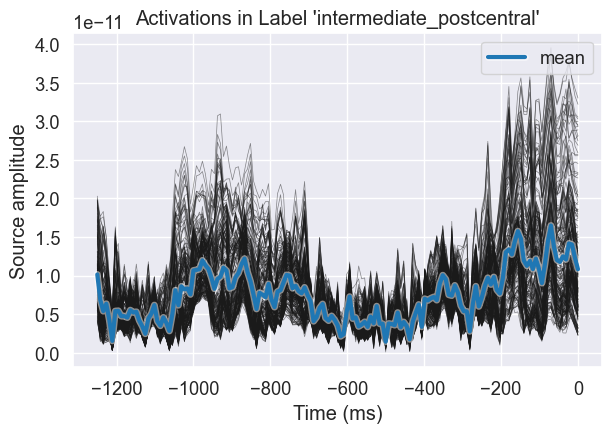

In [ ]:
def get_all_tcs(output_dir, rel_motor_epochs, file_name = 'source_time_courses', overwrite=False):
    if not overwrite and os.path.isfile(f"{output_dir}{file_name}.pickle"):
        all_tcs = pickle.load(open(f"{output_dir}{file_name}.pickle", 'rb'))
        return np.concatenate(all_tcs)
    else:
        bin_size = 500 # number of sources to compute in batch
        mode = 'mean'
        count = 0
        all_tcs=[]
        while count*bin_size <= len(rel_motor_epochs):
            print('bin',count)
            stcs = mne.minimum_norm.apply_inverse_epochs(rel_motor_epochs[count*bin_size:(count+1)*bin_size], inverse_operator,
                                        lambda2=1.0 / snr ** 2, verbose=False,
                                        method="eLORETA") # , pick_ori="normal"?
            tcs = mne.extract_label_time_course(stcs, rel_labels, src=fwd['src'], mode=mode,verbose=False)
            all_tcs.append(tcs)
            count += 1
        # plot the last time course
        plot_source_time_course(ltc=tcs[0], orig_stc=stcs[0], label=rel_labels[0], mode = 'mean',rel_mappings=rel_mappings)
        with open(f"{output_dir}{file_name}.pickle", 'wb') as handle_ica:
            pickle.dump(all_tcs, handle_ica, protocol=pickle.HIGHEST_PROTOCOL)
    return np.concatenate(all_tcs)
# all_tcs = get_all_tcs(output_dir_non_baseline_non_average, motor_epochs, overwrite=False)
# assert len(all_tcs) == len(motor_epochs), 'the source data is not the same size as the motor_epochs, check this issue'
